## learning-AI101 : raisin classification
### 건포도 데이터를 SVM, random forest, decision tree, KNN, logistic regression 기법을 적용하여 classification

<br>

- **임규연 (lky473736)**
- 2024.07.14. ~ 2024.07.17.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/850/raisin
- **data abstract** : Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.

------

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

-------

### 1. 데이터 EDA (탐색적 데이터 분석)

classification을 진행하기 전, 데이터 구조를 파악한다.

- **데이터 구조 파악 및 EDA**
    - 각 feature가 의미하는 바를 분석, 결측치 파악 후 어떻게 classification을 진행하는 것이 탁월할 지 파악
    - 각 feature에 대한 사분위수, mean, max, min, median, corr
    - seaborn을 통한 corr 상관관계 및 histplot 시각화
    - 각 feature에 대한 box plot 시각화
    - target의 도수를 bar plot 시각화

#### 1-1) 파일 열기, 기초 통계량 분석 및 classifiaction 전략 도출

In [12]:
# 파일 열기

df = pd.read_excel('../data/Raisin_Dataset/Raisin_Dataset.xlsx')
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [13]:
# df의 행의 갯수, 열의 갯수, feature 파악

df.shape, df.columns

((900, 8),
 Index(['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
        'ConvexArea', 'Extent', 'Perimeter', 'Class'],
       dtype='object'))

In [49]:
# df의 기본적인 통계량 수치 파악, 각 열마다 결측치 여부 파악

for feature in df.columns :
    print (f'{feature}의 데이터 타입 : ', df[feature].dtype)

df.describe()

Area의 데이터 타입 :  int64
MajorAxisLength의 데이터 타입 :  float64
MinorAxisLength의 데이터 타입 :  float64
Eccentricity의 데이터 타입 :  float64
ConvexArea의 데이터 타입 :  int64
Extent의 데이터 타입 :  float64
Perimeter의 데이터 타입 :  float64
Class의 데이터 타입 :  object


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


범위와 척도를 통일하기 위하여 정수형인 'Area' 열과 'ConvexArea' 열을 **연속형으로 변경**할 예정이다. 각 feature가 의미하는 바와 그에 따른 classification 전략은 아래와 같다.

- **Area**
  - 건포도의 전체 면적
  - 정수형, min과 max의 차이가 커서 분포가 넓다.
  - mean이 median보다 작기 때문에 우측 편향일 가능성이 있다.

- **MajorAxisLength**
  - 주축 길이
  - 연속형, mean이 median보다 작기 때문에 우측 편향일 가능성이 있다.

- **MinorAxisLength**
  - 단축 길이
  - 연속형, 주축 길이보다는 min과 max의 차이가 작아 분포가 좁다.

- **Eccentricity**
  - 이심율
  - 연속형, 0에서 1 사이의 값을 가지면서 median이 0.7에 가까운 것을 보아 건포도가 타원형임을 알 수 있다. 

- **ConvexArea**
  - 볼록한 껍질의 면적
  - 정수형, 우측 편향일 가능성이 있다.

- **Extent**
  - 가장 작은 볼록한 껍질의 면적
  - 연속형, 평균과 중앙값이 거의 일치한다.

- **Perimeter**
  - 건포도에 의해 형성된 영역의 둘레를 바운딩 박스 내 총 픽셀 수로 나눈 비율
  - 연속형, Area와 유사한 분포를 보인다.

- **Class**
  - Kecimen과 Besni 건포도를 구분
  - 범주형, target 데이터

<br>

- **classification 전략**
    - 'Class' 열을 target data로 선정하고, 나머지 열을 feature로 삼아 classification하자.
    - 데이터를 아래와 같이 준비
        - 특성 변수(Feature): Area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea, Extent, Perimeter
        - 타겟 변수(Target): Class
    - SVM, KNN, logistic regression 전에 StandardScaler를 통한 스케일링이 필요

#### 1-2) seaborn을 통한 상관관계 heatmap 및 전체 histplot 시각화

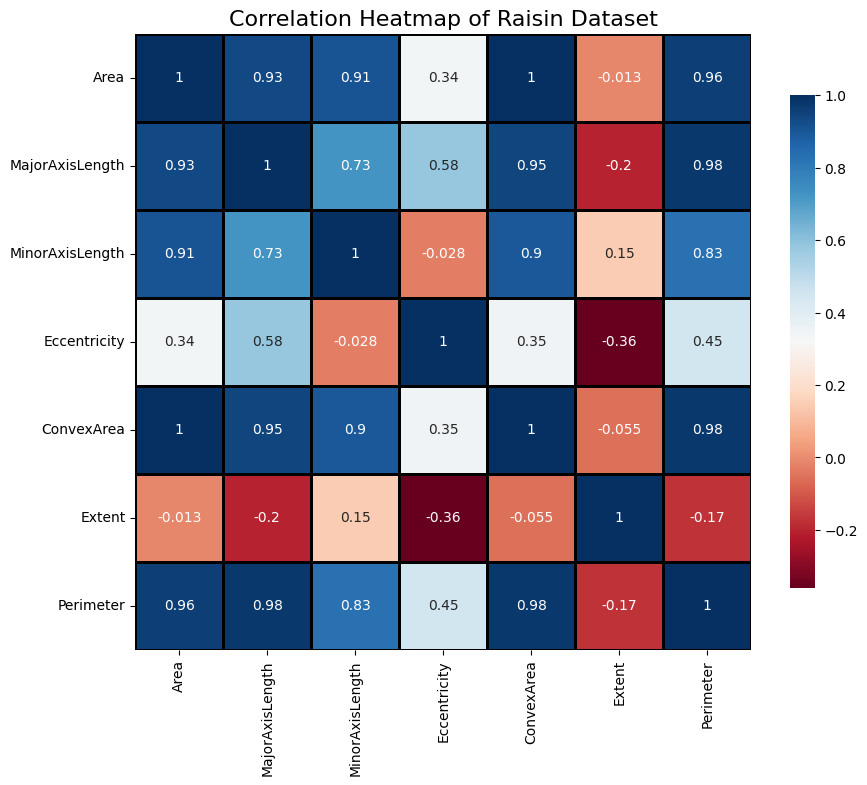

In [15]:
# seaborn을 통하여 heatmap 시각화
# 상관계수 행렬, 각 변수 간의 선형적 관계를 시각적으로 표시

correlation_matrix = df[['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
        'ConvexArea', 'Extent', 'Perimeter']].corr() # feature (target 제외)
plt.figure(figsize=(10, 8)) 
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', square=True,
            linewidths=1, linecolor='black', cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of Raisin Dataset', fontsize=16)
plt.show()

위 heatmap는 음수로 갈 수록 음의 상관관계(반비례), 양수로 갈 수록 양의 상관관계(정비례)를 의미한다. 또한 diagonal을 중심으로 각 part가 대칭이다. (symmetric) figure를 보고 주목해야 할 부분은 아래와 같이 분석할 수 있다.

- **높은 상관관계**
     - Area와 ConvexArea (1.0): 두 변수는 완벽한 양의 상관관계를 가지고 있다. 이는 ConvexArea가 Area와 매우 유사한 정보를 담고 있다. 따라서 추후 모델링 과정에서 두 특성 중 하나만 사용해도 될 것으로 추측된다.
     - Area와 Perimeter (0.96): 면적과 둘레 사이에 매우 높은 양의 상관관계를 가지고 있다. 그러면 큰 면적을 가진 건포도가 둘레도 길 것이다.
     - MajorAxisLength와 Perimeter (0.98): 주축 길이와 둘레 사이에 매우 높은 양의 상관관계를 가진다.
     - MajorAxisLength와 ConvexArea (0.95): 주축 길이와 ConvexArea 사이에 높은 양의 상관관계를 가진다.
     - Area와 MajorAxisLength (0.93), Area와 MinorAxisLength (0.91): 면적이 클수록 주축과 단축 길이가 길어진다.
     
- **낮은 상관관계**
    - Extent와 대부분의 다른 변수들: Extent는 다른 대부분의 변수들과 상관관계가 매우 낮다. 특히 Area (-0.013)와 거의 상관관계가 없다. 따라서 추후 모델링 과정에서 Extent를 제거하여도 큰 문제가 되지 않을 것으로 추측된다.
    - MinorAxisLength와 Eccentricity (-0.028): 단축 길이와 이심률 사이의 상관관계는 매우 낮다.

분석 과정 중 Area와 ConvexArea 중 하나를 제거하는 여부 및 Extent의 제거 여부에 따른 학습 score의 변화를 logistic regression 분석 시 확인해보자.

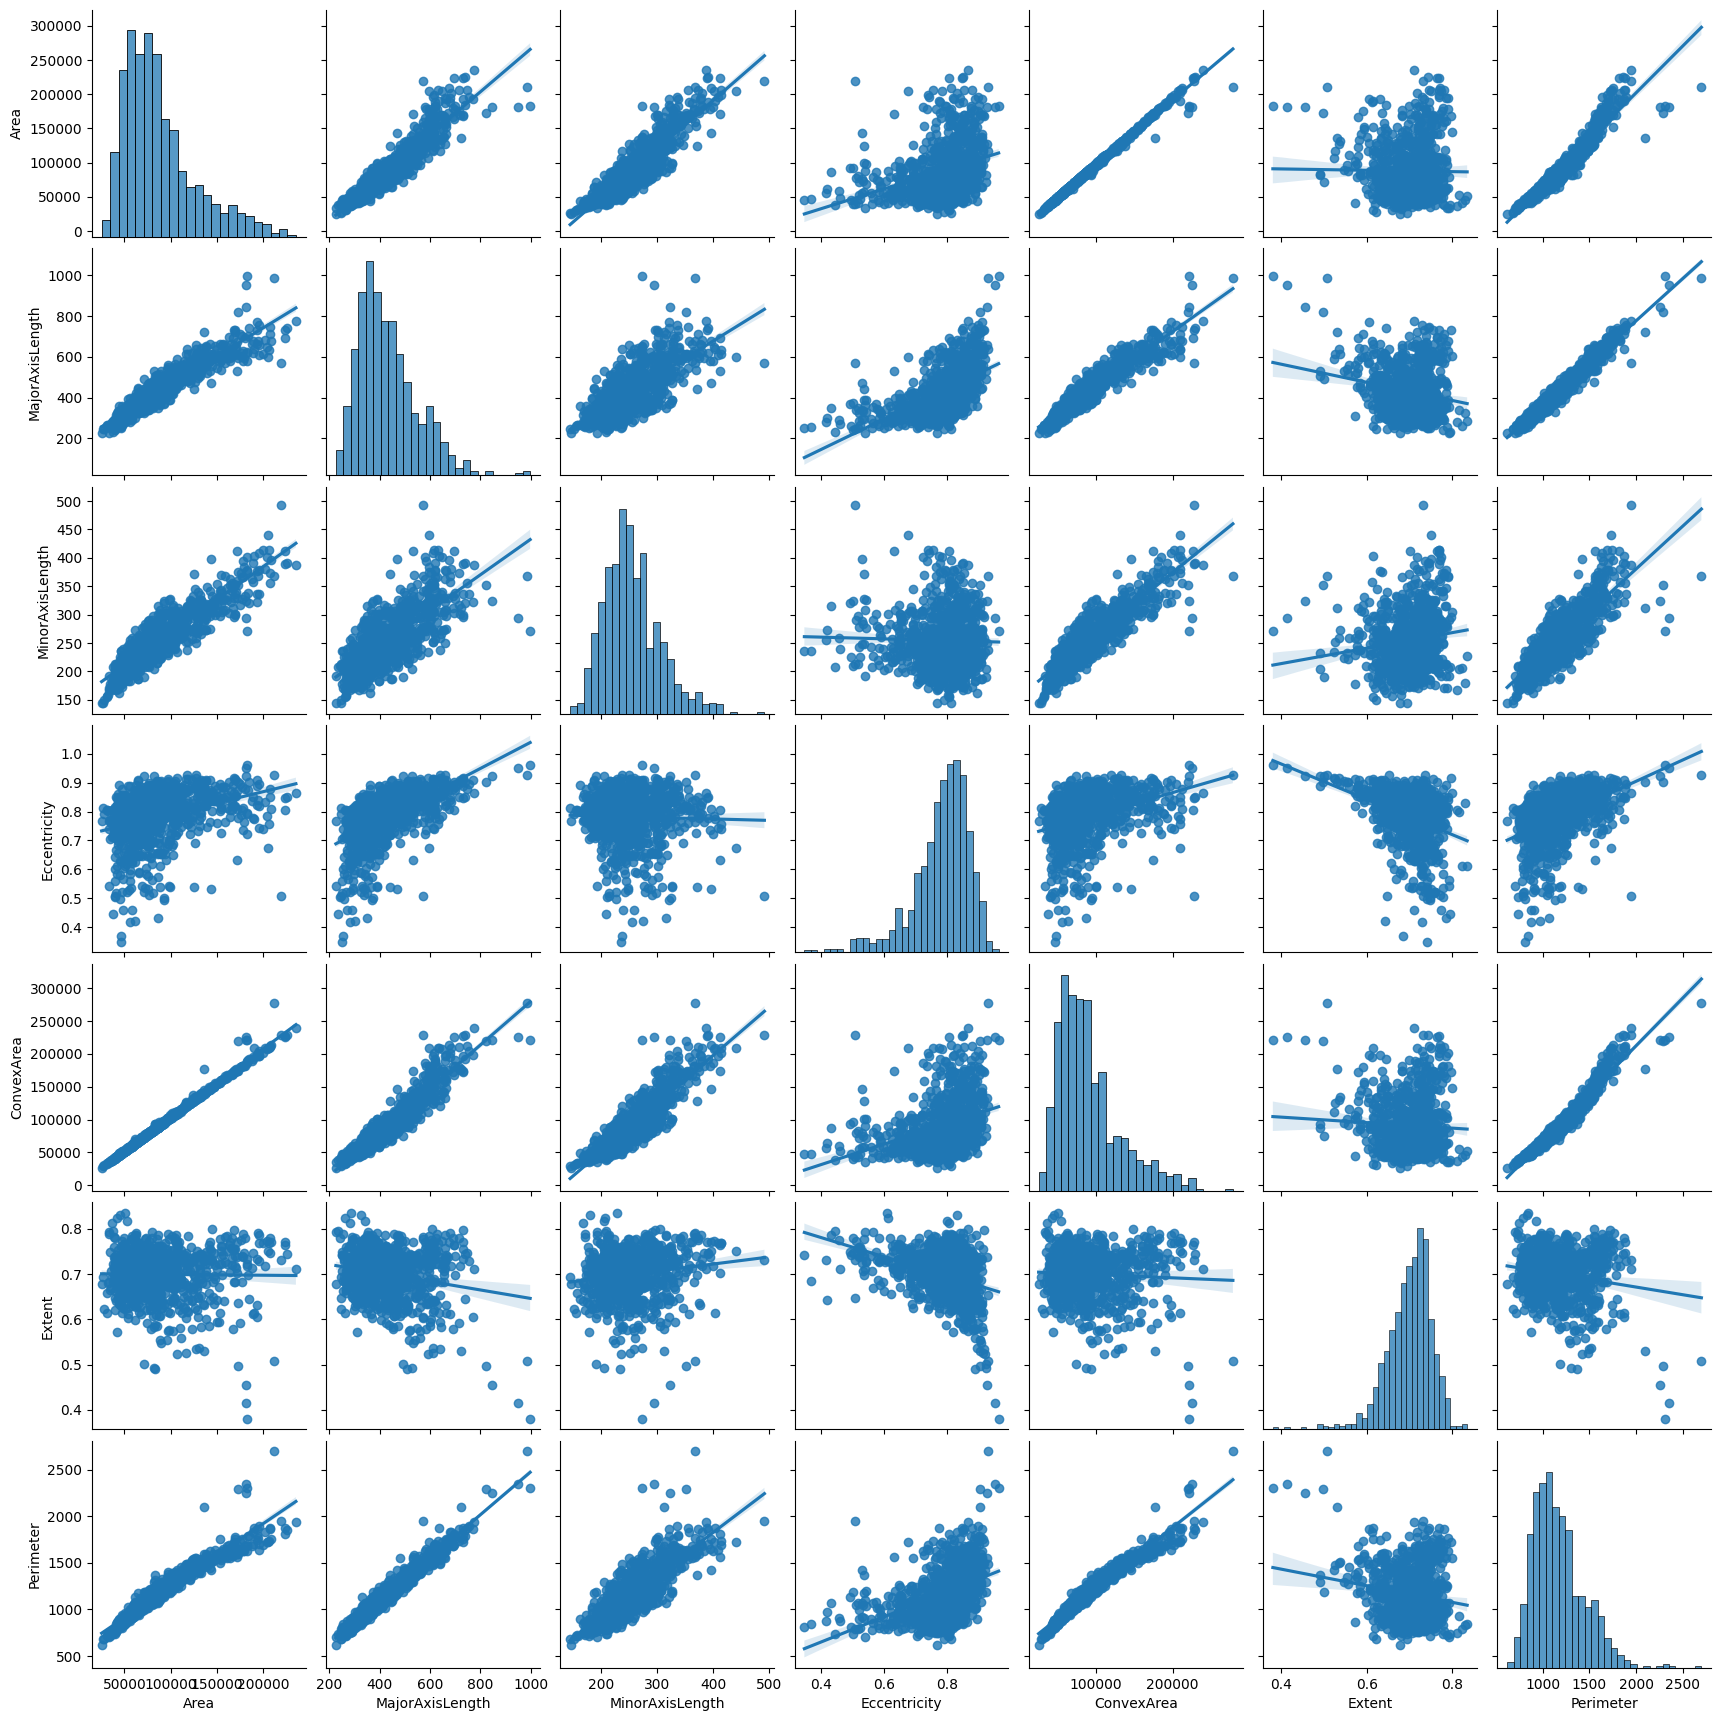

In [56]:
# seaborn을 통하여 pairplot 시각화
# 현재 데이터프레임의 모든 열 쌍에 대한 산점도와 히스토그램을 시각화한다

sns.pairplot(df[['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
        'ConvexArea', 'Extent', 'Perimeter']], kind="reg") # feature (target 제외)
plt.show()

------

#### 1-3) 각 feature에 대한 box plot 시각화



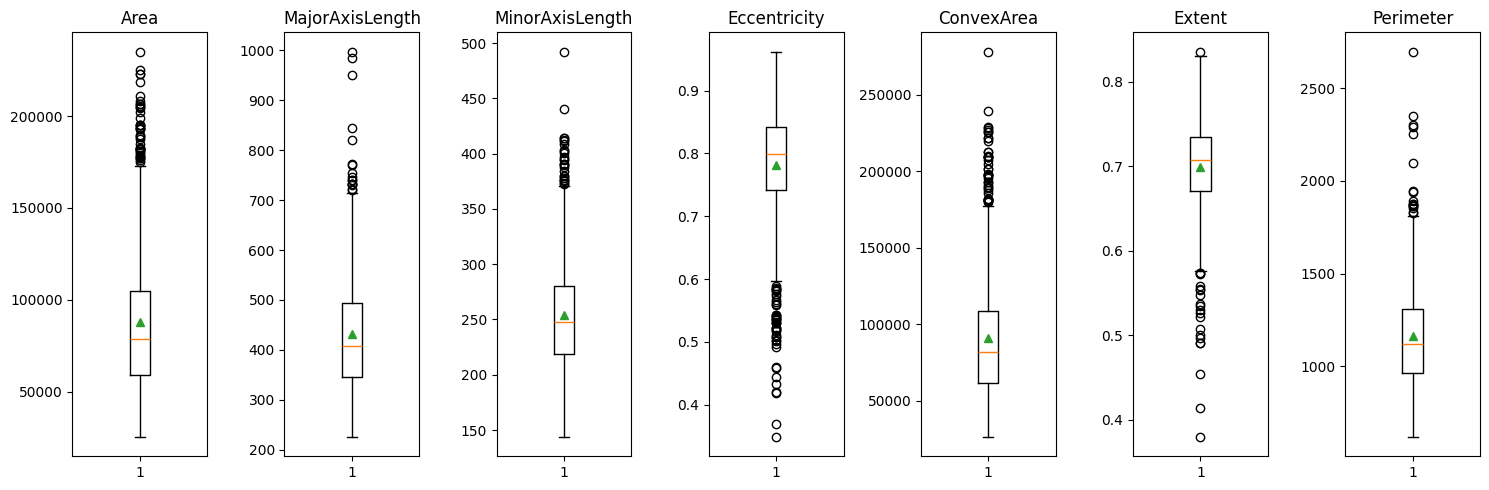

In [29]:
# box plot 그려 데이터 분포 확인

attr_list = ['Area', 'MajorAxisLength', 'MinorAxisLength', 
             'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']

# subplot 생성
fig, axes = plt.subplots(nrows=1, ncols=len(attr_list), figsize=(15, 5))

# 각 변수에 대한 boxplot 그리기
for i, var in enumerate(attr_list) :
    ax = axes[i]
    ax.boxplot(df[var], showmeans=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

------

#### 1-4) target의 갯수를 bar plot으로 시각화



In [31]:
# bar plot 그려 target의 class의 도수를 파악
# 도수를 알기 위해 unique 매소드 사용

target = np.unique(df['Class'])
print (target)

['Besni' 'Kecimen']


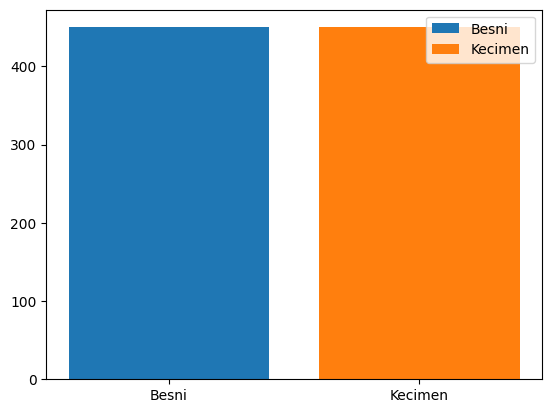

In [43]:
# 시각화 진행

plt.bar('Besni', len(df[df['Class'] == 'Besni']), label='Besni')
plt.bar('Kecimen', len(df[df['Class'] == 'Kecimen']), label='Kecimen')
plt.legend()
plt.show()

위 bar plot을 확인해보니 두 class 각각의 도수가 동일한 것을 확인할 수 있다. 따라서 샘플링 편향은 일어나지 않을 것이다.

------

### 2. 데이터 전처리

1에서 분석한 바를 토대로 전처리를 진행한다.
- **전처리**
    - 결측치는 그 feature (열)의 평균으로 fill
    - 이상치는 제거 
    - 만약 scale이 많이 다르다면 Z-score normalization 진행 

#### 2-1) 결측치 확인 및 fill 

In [51]:
# 결측치 확인

for feature in df.columns :
    print (f'{feature}열의 결측치 존재 여부 : ', df[feature].isnull())
    print ('\n--------------\n')

print ("데이터의 총 결측치 수 : ", df.isnull().sum())

Area열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: Area, Length: 900, dtype: bool

--------------

MajorAxisLength열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: MajorAxisLength, Length: 900, dtype: bool

--------------

MinorAxisLength열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: MinorAxisLength, Length: 900, dtype: bool

--------------

Eccentricity열의 결측치 존재 여부 :  0      False
1      False
2      False
3      False
4      False
       ...  
895    False
896    False
897    False
898    False
899    False
Name: Eccentricity, Length: 900, dtype: bool

--------------

ConvexArea열의 결측치 존재 여부 :  0      False
1      False
2      False
3      

위를 보면, 본 데이터에 결측치가 **전혀** 존재하지 않고 있다. 따라서 결측치에 따른 전처리를 진행하지 않아도 된다.

#### 2-2) 정규화 (normalization) - Z-score normalization
- 각 feature의 scale이 서로 달라, SVM, KNN, logistic regression 전에 StandardScaler를 통한 스케일링이 필요
- 따라서 StandardScaler를 통한 Z-score normalization을 수행

In [52]:
# input과 target으로 df를 split

raisin_input = df[['Area', 'MajorAxisLength', 'MinorAxisLength', 
             'Eccentricity', 'ConvexArea', 'Extent', 'Perimeter']].to_numpy() 
raisin_target = df['Class'].to_numpy()

In [53]:
# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split

from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(raisin_input, raisin_target, 
                                                   stratify=raisin_target)

In [55]:
# StandardScaler을 통한 정규화 진행

from sklearn.preprocessing import StandardScaler
ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)

-------

### 3. 각종 모델을 적용하여 classification
- SVM, random forest, decision tree, KNN, logistic regression 기법을 적용하여 classification
- 순서는 KNN, logistic regression, decision tree, random forest, SVM

#### 3-1) KNN